In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime, nltk, warnings
import itertools

In [2]:
from pathlib import Path
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display, HTML

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

In [3]:
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use("fivethirtyeight")
mpl.rc("patch", edgecolor="dimgray", linewidth=1)
%matplotlib inline

In [4]:
df_initial = pd.read_csv("sales_data.csv", encoding="unicode_escape")

In [5]:
df_initial

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [6]:
print("Dataframe dimensions:", df_initial.shape)

df_initial["InvoiceDate"] = pd.to_datetime(df_initial["InvoiceDate"])

# give some infos on columns type and num of null values
tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0:"column type"})
display(tab_info)

# show first lines
display(df_initial[:5])

Dataframe dimensions: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,float64,object


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
print("중복값 제거: {}".format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace=True)

중복값 제거: 5268


In [8]:
temp = df_initial[["CustomerID", "InvoiceNo", "Country"]].groupby(["CustomerID", "InvoiceNo", "Country"]).count()
temp = temp.reset_index(drop=False)
countries = temp["Country"].value_counts()
print("중복 국가 제거: {}".format(len(countries)))

중복 국가 제거: 37


In [9]:
# 국가 시각화
data = dict(type="choropleth", 
            locations = countries.index, 
            locationmode = "country names", 
            z = countries, 
            text = countries.index, 
            colorbar = {"title": "Order nb."}, 
            colorscale = [[0, "rgb(224,255,255)"], 
                          [0.01, "rgb(166,206,227)"], 
                          [0.02, "rgb(31,120,180)"], 
                          [0.03, "rgb(178,223,138)"], 
                          [0.05, "rgb(51,160,44)"], 
                          [0.10, "rgb(251,154,153)"], 
                          [0.20, "rgb(255,255,0)"], 
                          [1, "rgb(227,26,28)"]], 
           reversescale = False)

layout = dict(title = "Number of orders per country", 
              geo = dict(showframe = True, 
                         projection = {"type": "mercator"}))

choromap = go.Figure(data=[data], layout=layout)
iplot(choromap, validate=False)

- Customers and products

---
- sales 데이터에서 quantity < 0, 작은 값 등이 있었다.
- 실질적으로 주문 취소에 대한 인사이트 이 부분을 잡아서 정리하는 코드가 아래에 있다.
- 전처리하는 동안에 해당 도메인에 대한 로직을 이해하고 정리한다.

In [10]:
pd.DataFrame([{"products": len(df_initial["StockCode"].value_counts()), 
               "transactions": len(df_initial["InvoiceNo"].value_counts()), 
               "customers": len(df_initial["CustomerID"].value_counts())}], 
             columns=["products", "transactions", "customers"], 
             index=["quantity"])

,products,transactions,customers
quantity,4070,25900,4372


In [11]:
temp = df_initial.groupby(by=["CustomerID", "InvoiceNo"], as_index=False)["InvoiceDate"].count()
nb_products_per_basket = temp.rename(columns={"InvoiceDate": "Number of products"})
nb_products_per_basket[:10].sort_values("CustomerID")

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


In [12]:
nb_products_per_basket["order_canceled"] = nb_products_per_basket["InvoiceNo"].apply(lambda x: int("C" in x))
display(nb_products_per_basket[:5])

n1 = nb_products_per_basket["order_canceled"].sum()
n2 = nb_products_per_basket.shape[0]
print("Number of orders canceled: {}/{} ({:.2f}%)".format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


Number of orders canceled: 3654/22190 (16.47%)


In [13]:
display(df_initial.sort_values("CustomerID")[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347.0,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347.0,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347.0,Iceland


In [14]:
df_check = df_initial[df_initial["Quantity"] < 0][["CustomerID", "Quantity", "StockCode", "Description", "UnitPrice"]]

for index, col in df_check.iterrows():
    if df_initial[(df_initial["CustomerID"] == col[0]) & (df_initial["Quantity"] == -col[1]) 
                  & (df_initial["Description"] == col[2])].shape[0] == 0:
        print(df_check.loc[index])
        print(15 * "-" + ">" + " HYPOTHESIS NOT FULFILLED")
        break

CustomerID      14527.0
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [15]:
df_check = df_initial[(df_initial["Quantity"] < 0) & (df_initial["Description"] != "Discount")][["CustomerID", "Quantity", "StockCode", "Description", "UnitPrice"]]

for index, col in df_check.iterrows():
    if df_initial[(df_initial["CustomerID"] == col[0]) & (df_initial["Quantity"] == -col[1]) 
                  & (df_initial["Description"] == col[2])].shape[0] == 0:
        print(df_check.loc[index])
        print(15 * "-" + ">" + " HYPOTHESIS NOT FULFILLED")
        break

CustomerID                             15311.0
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [16]:
df_cleaned = df_initial.copy(deep=True)
df_cleaned["QuantityCanceled"] = 0

entry_to_remove = []
doubtful_entry = []

for index, col in df_initial.iterrows():
    if (col["Quantity"] > 0) or col["Description"] == "Discount": continue
    df_test = df_initial[(df_initial["CustomerID"] == col["CustomerID"]) & 
                         (df_initial["StockCode"] == col["StockCode"]) & 
                         (df_initial["InvoiceDate"] < col["InvoiceDate"]) & 
                         (df_initial["Quantity"] > 0)].copy()
    
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0):
        doubtful_entry.append(index)
    
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, "QuantityCanceled"] = -col["Quantity"]
        entry_to_remove.append(index)
    
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1):
        df_test.sort_index(axis=0, ascending=False, inplace=True)
        
        for ind, val in df_test.iterrows():
            if val["Quantity"] < -col["Quantity"]: continue
            df_cleaned.loc[ind, "QuantityCanceled"] = -col["Quantity"]
            entry_to_remove.append(index)
            break

In [17]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtful_entry: {}".format(len(doubtful_entry)))

entry_to_remove: 7521
doubtful_entry: 2941


In [18]:
df_cleaned.drop(entry_to_remove, axis=0, inplace=True)
df_cleaned.drop(doubtful_entry, axis=0, inplace=True)
remaining_entries = df_cleaned[(df_cleaned["Quantity"] < 0) & (df_cleaned["StockCode"] != "D")]

print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358.0,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659.0,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048.0,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422.0,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754.0,United Kingdom,0


- Quantity 변수 이상치와 Stockcode 이상치들을 확인하여 정리함

In [19]:
df_cleaned[(df_cleaned["CustomerID"] == 14048) & (df_cleaned["StockCode"] == "22464")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
84247,543371,22464,HANGING METAL HEART LANTERN,3,2011-02-07 14:53:00,1.65,14048.0,United Kingdom,0
84259,543371,22464,HANGING METAL HEART LANTERN,1,2011-02-07 14:53:00,1.65,14048.0,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048.0,United Kingdom,0


In [20]:
df_cleaned[df_cleaned["Quantity"] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,0
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527.0,United Kingdom,0
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498.0,United Kingdom,0
19392,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340.0,United Kingdom,0
31134,C538897,D,Discount,-1,2010-12-15 09:14:00,5.76,16422.0,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
516455,C579908,D,Discount,-1,2011-12-01 08:49:00,28.68,14527.0,United Kingdom,0
516775,C579948,21098,CHRISTMAS TOILET ROLL,-3,2011-12-01 10:56:00,1.25,16376.0,United Kingdom,0
520133,C580263,M,Manual,-4,2011-12-02 12:43:00,9.95,12536.0,France,0
520134,C580263,M,Manual,-16,2011-12-02 12:43:00,0.29,12536.0,France,0


- StockCode

In [21]:
list_special_codes = df_cleaned[df_cleaned["StockCode"].str.contains("^[a-zA-Z]+", regex=True)]["StockCode"].unique()
list_special_codes

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0069',
       'DCGSSBOY', 'DCGSSGIRL', 'gift_0001_10', 'S', 'PADS', 'DCGS0004',
       'B'], dtype=object)

In [22]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned["StockCode"] == code]["Description"].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
DOT             -> DOTCOM POSTAGE                
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
AMAZONFEE       -> AMAZON FEE                    
DCGS0076        -> SUNJAR LED NIGHT NIGHT LIGHT  
DCGS0003        -> BOXED GLASS ASHTRAY           
gift_0001_40    -> Dotcomgiftshop Gift Voucher £40.00
DCGS0070        -> CAMOUFLAGE DOG COLLAR         
m               -> Manual                        
gift_0001_50    -> Dotcomgiftshop Gift Voucher £50.00
gift_0001_30    -> Dotcomgiftshop Gift Voucher £30.00
gift_0001_20    -> Dotcomgiftshop Gift Voucher £20.00
DCGS0069        -> OOH LA LA DOGS COLLAR         
DCGSSBOY        -> BOYS PARTY BAG                
DCGSSGIRL       -> GIRLS PARTY BAG               
gift_0001_10    -> Dotcomgiftshop Gift Voucher £10.00
S               -> SAMPLES    

- Basket Price

In [23]:
df_cleaned["TotalPrice"] = df_cleaned["UnitPrice"] * (df_cleaned["Quantity"] - df_cleaned["QuantityCanceled"])
df_cleaned.sort_values("CustomerID")[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347.0,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347.0,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347.0,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347.0,Iceland,0,35.7


In [24]:
# sum of purchases / user & order
temp = df_cleaned.groupby(by=["CustomerID", "InvoiceNo"], as_index=False)["TotalPrice"].sum()
basket_price = temp.rename(columns={"TotalPrice":"Basket Price"})

# date of order
df_cleaned["InvoiceDate_int"] = df_cleaned["InvoiceDate"].astype("int64")
temp = df_cleaned.groupby(by=["CustomerID", "InvoiceNo"], as_index=False)["InvoiceDate_int"].mean()
df_cleaned.drop("InvoiceDate_int", axis=1, inplace=True)
basket_price.loc[:, "InvoiceDate"] = pd.to_datetime(temp["InvoiceDate_int"])

# selection of significant entries
basket_price = basket_price[basket_price["Basket Price"] > 0]
basket_price.sort_values("CustomerID")[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347.0,537626,711.79,2010-12-07 14:57:00.000000000
2,12347.0,542237,475.39,2011-01-26 14:29:59.999999744
3,12347.0,549222,636.25,2011-04-07 10:43:00.000000000
4,12347.0,556201,382.52,2011-06-09 13:01:00.000000000
5,12347.0,562032,584.91,2011-08-02 08:48:00.000000000
6,12347.0,573511,1294.32,2011-10-31 12:25:00.000000000


Text(0.5, 1.01, 'Distribution of order amounts')

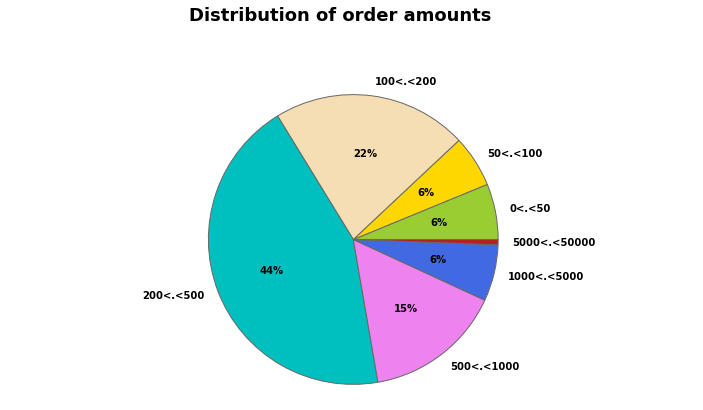

In [25]:
# accounts of procurement
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []

for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price["Basket Price"] < price) & 
                       (basket_price["Basket Price"] > price_range[i-1])]["Basket Price"].count()
    count_price.append(val)

# representation of the number of purchases / amounts
plt.rc("font", weight="bold")
f, ax = plt.subplots(figsize=(11, 6))
colors = ["yellowgreen", "gold", "wheat", "c", "violet", "royalblue", "firebrick"]
labels = ["{}<.<{}".format(price_range[i-1], s) for i, s in enumerate(price_range) if i != 0 ]
sizes = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode=explode, labels=labels, colors=colors, 
       autopct=lambda x:"{:1.0f}%".format(x) if x > 1 else "", 
       shadow=False, startangle=0)
ax.axis("equal")
f.text(0.5, 1.01, "Distribution of order amounts", ha="center", fontsize=18)

- Insight on product categories

In [33]:
is_noun = lambda pos: pos[:2] == "NN"

def keywords_inventory(dataframe, colonne="Description"):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots = dict() # collect the words / root
    keywords_select = dict() # association: root <-> keyword
    category_keys = []
    count_keywords = dict()
    icount = 0
    
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
        
        for t in nouns:
            t = t.lower()
            racine = stemmer.stem(t)
            
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)
            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
    
    print("Nb of keywords in variable '{}': {}".format(colonne, len(category_keys)))
    
    return category_keys, keywords_roots, keywords_select, count_keywords

In [34]:
df_produits = pd.DataFrame(df_initial["Description"].unique()).rename(columns={0: "Description"})

In [35]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1603


- unique한 값들을 잘 정리하려고 함

In [36]:
list_products = []

for k, v in count_keywords.items():
    list_products.append([keywords_select[k], v])

list_products.sort(key=lambda x: x[1], reverse=True)

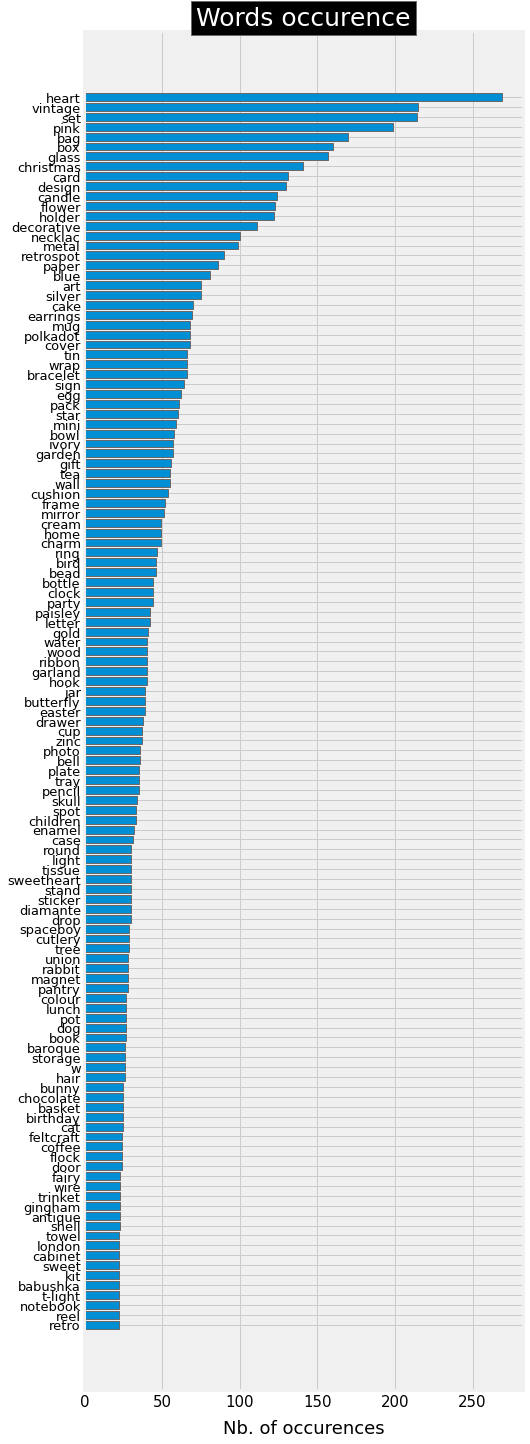

In [37]:
liste = sorted(list_products, key=lambda x: x[1], reverse=True)

plt.rc("font", weight="normal")
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k, i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize=18, labelpad=10)
ax.barh(x_axis, y_axis, align="center")
ax = plt.gca()
ax.invert_yaxis()
plt.title("Words occurence", bbox={"facecolor":"k", "pad":5}, color="w", fontsize=25)
plt.show()

- 최소 13 이상만 남기고 나머지를 제거하기

In [38]:
list_products = []

for k, v in count_keywords.items():
    word = keywords_select[k]
    
    if word in ["pink", "blue", "tag", "green", "orange"]: continue
    if len(word) < 3 or v < 13: continue
    if ("+" in word) or ("/" in word): continue
    list_products.append([word, v])

list_products.sort(key=lambda x: x[1], reverse=True)
print("retained words:", len(list_products))

retained words: 197


In [39]:
list_products

[['heart', 269],
 ['vintage', 215],
 ['set', 214],
 ['bag', 170],
 ['box', 160],
 ['glass', 157],
 ['christmas', 141],
 ['card', 131],
 ['design', 130],
 ['candle', 124],
 ['flower', 123],
 ['holder', 122],
 ['decorative', 111],
 ['necklac', 100],
 ['metal', 99],
 ['retrospot', 90],
 ['paper', 86],
 ['art', 75],
 ['silver', 75],
 ['cake', 70],
 ['earrings', 69],
 ['mug', 68],
 ['polkadot', 68],
 ['cover', 68],
 ['tin', 66],
 ['wrap', 66],
 ['bracelet', 66],
 ['sign', 64],
 ['egg', 62],
 ['pack', 61],
 ['star', 60],
 ['mini', 59],
 ['bowl', 58],
 ['ivory', 57],
 ['garden', 57],
 ['gift', 56],
 ['tea', 55],
 ['wall', 55],
 ['cushion', 54],
 ['frame', 52],
 ['mirror', 51],
 ['cream', 49],
 ['home', 49],
 ['charm', 49],
 ['ring', 47],
 ['bird', 46],
 ['bead', 46],
 ['bottle', 44],
 ['clock', 44],
 ['party', 44],
 ['paisley', 42],
 ['letter', 42],
 ['gold', 41],
 ['water', 40],
 ['wood', 40],
 ['ribbon', 40],
 ['garland', 40],
 ['hook', 40],
 ['jar', 39],
 ['butterfly', 39],
 ['easter', 39]

In [83]:
liste_produits_init = df_cleaned["Description"].unique()
liste_produits = np.delete(liste_produits_init, 391)
X = pd.DataFrame()

for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x: int(key.upper() in x), liste_produits))

In [84]:
X

,heart,vintage,set,bag,box,glass,christmas,card,design,candle,...,funky,tidy,plant,diner,house,square,craft,lace,jewel,point
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4073,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4074,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4075,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4076,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []

for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = ".>{}".format(threshold[i])
    else:
        col = "{}<.<{}".format(threshold[i], threshold[i+1])
    
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[df_cleaned["Description"] == prod]["UnitPrice"].mean()
    j = 0
    
    while prix > threshold[j]:
        j += 1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [87]:
label_col

['0<.<1', '1<.<2', '2<.<3', '3<.<5', '5<.<10', '.>10']

In [89]:
X

,heart,vintage,set,bag,box,glass,christmas,card,design,candle,...,craft,lace,jewel,point,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4073,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4074,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4075,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4076,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [90]:
print("{:<8} {:<20} \n".format("range", "nb. products") + 20*"-")
for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = ".>{}".format(threshold[i])
    else:
        col = "{}<.<{}".format(threshold[i], threshold[i+1])
    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    nb. products         
--------------------
0<.<1       726                 
1<.<2       995                 
2<.<3       737                 
3<.<5       739                 
5<.<10      594                 
.>10        287                 


In [93]:
matrix = X.to_numpy()

for n_clusters in range(3, 10):
    kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", str(n_clusters) + ",", "the average silhouette_score is:", silhouette_avg)

For n_clusters = 3, the average silhouette_score is: 0.09494720330139371
For n_clusters = 4, the average silhouette_score is: 0.11675180833323143
For n_clusters = 5, the average silhouette_score is: 0.14134029097062156
For n_clusters = 6, the average silhouette_score is: 0.13586515274239522
For n_clusters = 7, the average silhouette_score is: 0.1444765299010754
For n_clusters = 8, the average silhouette_score is: 0.13045428680321222
For n_clusters = 9, the average silhouette_score is: 0.1450973654781636


In [101]:
n_clusters = 5
silhouette_avg = -1

while silhouette_avg < 0.14:
    kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", str(n_clusters) + ",", "the average silhouette_score is:", silhouette_avg)

For n_clusters = 5, the average silhouette_score is: 0.14105668008730568


In [102]:
pd.Series(clusters).value_counts()

1    1026
3     995
2     737
0     726
4     594
dtype: int64

In [103]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use("fivethirtyeight")
    mpl.rc("patch", edgecolor="dimgray", linewidth=1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    
    for i in range(n_clusters):
        # aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                          facecolor=color, edgecolor=color, alpha=0.8)
        
        # label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color="red", fontweight="bold", 
                 bbox=dict(facecolor="white", edgecolor="black", boxstyle="round, pad=0.3"))
        
        # compute the new y_lower for next plot
        y_lower = y_upper + 10

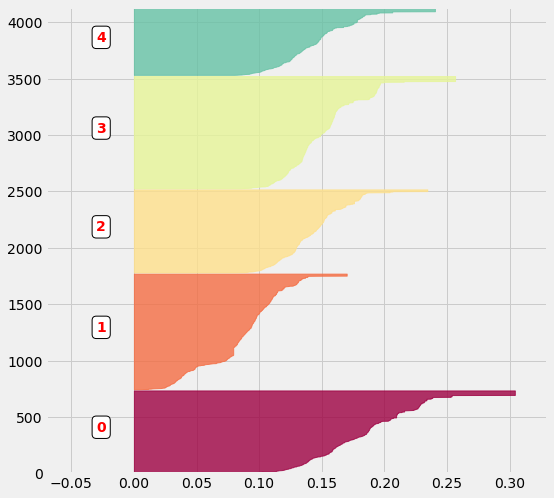

In [104]:
# define individual silhouette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)

# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

- Word Cloud

In [105]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    
    for word in liste_words:
        if word in ["art", "set", "heart", "pink", "blue", "tag"]: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

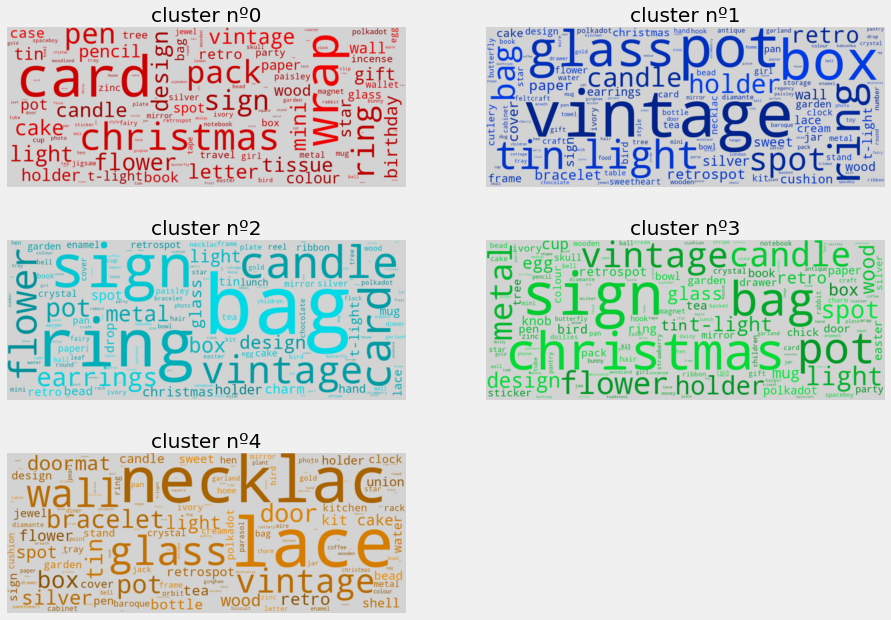

In [117]:
def random_color_func(word=None, font_size=None, position=None, 
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    
    return "hsl({}, {}%, {}%)".format(h, s, l)

def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4, 2, increment)
    words = dict()
    trunc_occurences = liste[0:150]
    
    for s in trunc_occurences:
        words[s[0]] = s[1]
    
    wordcloud = WordCloud(width=1000, height=400, background_color="lightgrey", 
                          max_words=1628, relative_scaling=1, 
                          color_func=random_color_func, 
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis("off")
    plt.title("cluster nº{}".format(increment-1))

fig = plt.figure(1, figsize=(14, 14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]

for i in range(n_clusters):
    list_cluster_occurences = occurence[i]
    tone = color[i] # define the color of the words
    liste = []
    
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    
    liste.sort(key=lambda x: x[1], reverse=True)
    make_wordcloud(liste, i+1)

- 비지도 학습을 통해 주작정 군집화도 가능하겠지만, 
- 전체 데이터에서 전처리를 통해 정리를 하고 -> 해당 데이터의 타입에서 새롭게 군집화를 진행하여서 인사이트를 도출할 수도 있다.
- word2vec, item2vec에 대한 개념으로 유사도 등을 측정하기 위해 메트릭스를 만든 것
- 군집화를 진행해서 인사이트를 뽑으려고 한 노력

---
- 군집 분석을 통해서 고객 데이터를 3개의 군집으로 만들었다.
- 이 군집을 통해서 CRM을 고도화 하기 위한 접근
- 해당 군집의 특성에 대해서 주문 건이나 주문 상품 등에 대한 차이를 통해 고객이 어떤 제품이나 상품을 좋아하는 경향이 있다.
- 앱푸쉬 LMS A/B 테스트를 하는 식으로 진행한다.

---
- 실제 전환율 등을 계산하여 개선 포인트를 찾는데
- 클러스터링에 들어갈 변수들이 정말 중요하다.
- 실제 클러스터링에 들어갈 변수들에 대해서 좀 더 도메인 지식적으로 고민을 하고 접근하는 것이 좋다.
- 많은 변수들을 다 넣은 상태로 군집화를 하게 되면 해석하기 어렵다,
- 오히려 가장 고객과 연관성이 높은 변수(ex) 주문 금액, 주문 상품)으로만 해도 의미 있는 결과가 나올 수 있는데, 너무 많은 컬럼을 넣은 상태로 진행하게 되면 문제가 될 수 있다.
- 차라리 군집화는 많은 변수를 이용하지 않고 merge를 통해서 인사이트를 찾아봐도 된다.

---
- 비지도 학습이라는 것이 결국에는 마법은 아니다.
- 고객의 특성이라는 거시적인 도메인 로직은 절대로 바뀌지가 않는다.
- 예를 들어서 의류를 판매하는 데이터, 식품을 판매하는 데이터, 가전 등을 판매하는 데이터, 명품을 판매하는 데이터
- 비지도 학습으로 어떤 유의미한 인사이트를 만들어 내겠다기보다는 하나의 보조 지표로 사용하는 것이 좋다.

---
- RFM frequency R M 지표를 만드는 것, 고객에 대한 지표
- RFM 어떤 식으로 고객 데이터가 움직이는지 -> 군집화까지 같이 진행해 보면서 확인